# Preamble

In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import scipy.io as sio
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_DWI/code/func/')
from proj_environment import set_proj_env
from func import mark_outliers, winsorize_outliers_signed

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude'
parc_str = 'schaefer'
parc_scale = 200
extra_str = ''
# extra_str = '_nuis-netdens'
# extra_str = '_nuis-str'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

### Setup output directory

In [4]:
print(os.environ['MODELDIR_BASE'])
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_DWI/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount
/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_DWI/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount


### Data processing options

In [5]:
wins_data = True
my_thresh = 3
norm_data = True

## Load data

In [6]:
# Load data
df = pd.read_csv(os.path.join(os.environ['MODELDIR_BASE'], 'df_pheno.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1080, 20)


In [7]:
# Load data
df_node = pd.read_csv(os.path.join(os.environ['MODELDIR_BASE'], 'df_node_base.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)
print(df_node.shape)

(1080, 1001)


In [8]:
df_node.head()

,,squeakycleanExclude,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,...,mc_190,mc_191,mc_192,mc_193,mc_194,mc_195,mc_196,mc_197,mc_198,mc_199
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,0,3.488284,3.083366,2.472731,2.547846,3.569930,2.253276,3.396373,2.483923,2.168940,...,0.960149,0.846447,0.898062,0.968343,0.994429,0.969654,0.954882,0.989007,0.983079,0.989130
80680,2739,1,3.462256,3.697656,3.466369,3.571828,3.714621,3.174863,4.512323,3.098134,2.784701,...,0.943066,0.887648,0.607192,0.808825,0.950077,0.927637,0.942159,0.979884,0.940173,0.976783
81754,2740,1,4.044139,3.771156,4.108147,3.254069,3.692766,3.031641,4.880243,4.258485,3.500267,...,0.906988,0.983757,0.929760,0.913886,0.961532,0.970058,0.985897,0.997719,0.984629,0.995997
81903,2749,0,3.643787,3.259916,2.765245,3.365504,4.320255,3.314894,4.241109,3.255931,3.299777,...,0.947557,0.983658,0.863792,0.947428,0.982539,0.958316,0.972199,0.996121,0.983827,0.994031
81043,2750,0,3.234094,3.047856,2.209638,3.434041,3.897574,3.020672,3.972496,3.273589,3.222844,...,0.873646,0.981272,0.822609,0.951068,0.990150,0.966714,0.978685,0.988349,0.971792,0.986702


In [9]:
metrics = ('ct', 'vol', 'str', 'ac', 'mc')
dwi_metrics = ('str', 'ac', 'mc')
t1_metrics = ('ct', 'vol')

### Compute whole brain averages

In [10]:
df_node_mean = pd.DataFrame(index = df_node.index, columns = metrics)
for metric in metrics:
    df_node_mean[metric] = df_node.filter(regex = metric, axis = 1).mean(axis = 1)

# Plots

In [11]:
# Labels
sns.set(style='white', context = 'talk', font_scale = 1)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


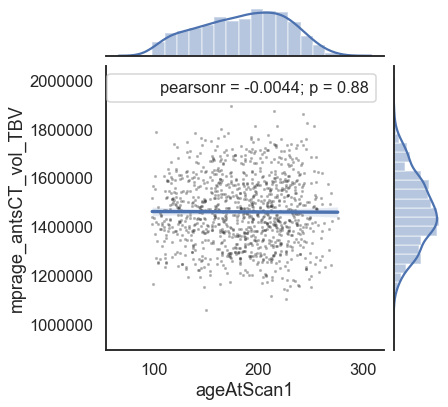

In [12]:
metric_x = 'ageAtScan1'
metric_y = 'mprage_antsCT_vol_TBV'
f = sns.jointplot(x = df[metric_x], y = df[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


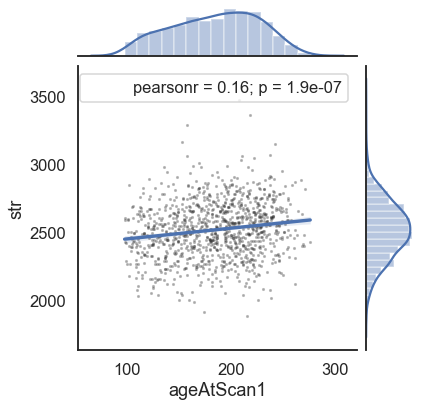

In [13]:
metric_x = 'ageAtScan1'
metric_y = 'str'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [14]:
metric_x = 'mprage_antsCT_vol_TBV'
# metric_x = 'network_density'
# metric_x = 'streamline_count'

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


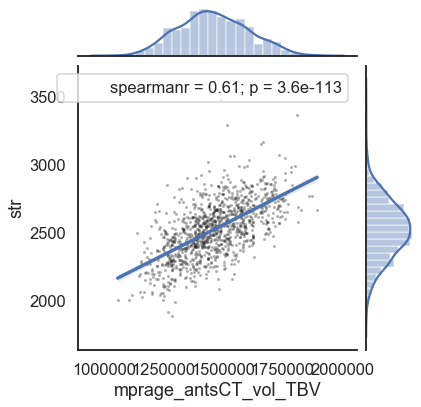

In [15]:
metric_y = 'str'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


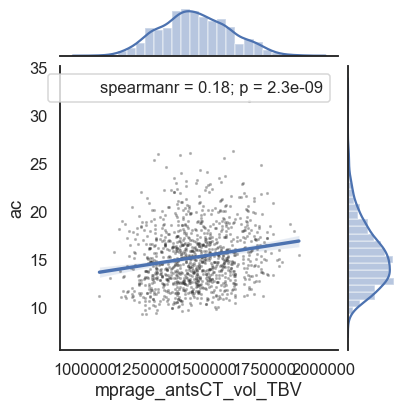

In [16]:
metric_y = 'ac'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


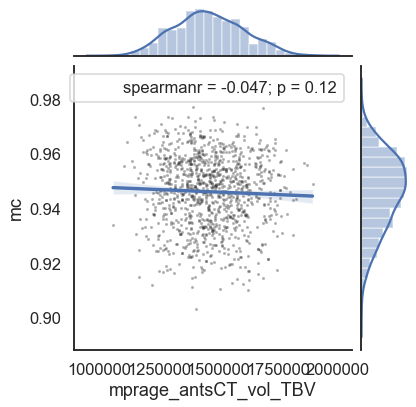

In [17]:
metric_y = 'mc'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [18]:
for metric in dwi_metrics:
    x = df_node.filter(regex = metric, axis = 1).mean(axis = 1)
    outliers = mark_outliers(x, thresh = my_thresh)
    print(metric + ': ' + str(np.round((outliers.sum() / x.shape[0]) * 100,2)))

str: 17.5
ac: 16.48
mc: 14.81


A higher threshold than 3 probably makes sense but sticking with convention to avoid 'kick me' signs with reviewers.

Note, results are unaffected by setting my_thresh to 4,5, or 6

### Check frequency of outliers

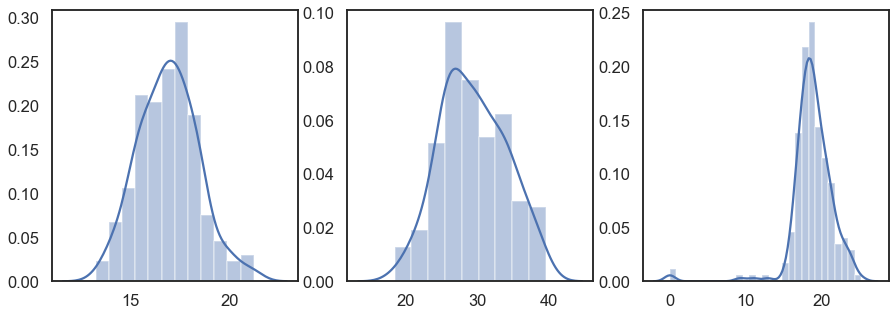

In [19]:
df_node_mask = pd.DataFrame(index = df_node.index, columns = df_node.columns)
for i, col in enumerate(df_node.columns):
    x = df_node.loc[:,col].copy()
    x_out = mark_outliers(x, thresh = my_thresh)
    df_node_mask.loc[:,col] = x_out

f, axes = plt.subplots(1,len(dwi_metrics))
f.set_figwidth(len(dwi_metrics)*5)
f.set_figheight(5)

for i, metric in enumerate(dwi_metrics):
    if df_node_mask.filter(regex = metric).sum().any():
        sns.distplot(df_node_mask.filter(regex = metric).sum()/df_node_mask.filter(regex = metric).shape[0]*100, ax = axes[i])

### Winsorize outliers

In [20]:
my_str = '|'.join(dwi_metrics); print(my_str)

str|ac|mc


In [21]:
if wins_data:
    for i, col in enumerate(df_node.filter(regex = my_str).columns):
        x = df_node.loc[:,col].copy()
        x_out = winsorize_outliers_signed(x, thresh = my_thresh)
        df_node.loc[:,col] = x_out
else:
    print('Skipping...')

## Normalize

In [22]:
if np.any(df_node<0):
    print('WARNING: some regional values are <0.. box cox will fail')

In [23]:
rank_r = np.zeros(df_node.filter(regex = my_str).shape[1])

In [24]:
# normalise
if norm_data:
    for i, col in enumerate(df_node.filter(regex = my_str).columns):
        # normalize regional metric
        x = sp.stats.boxcox(df_node.loc[:,col])[0]
        # check if rank order is preserved
        rank_r[i] = sp.stats.spearmanr(df_node.loc[:,col],x)[0]
        # store normalized version
        df_node.loc[:,col] = x
else:
    print('Skipping...')

In [25]:
np.sum(rank_r < .99)

0

### Check distributions

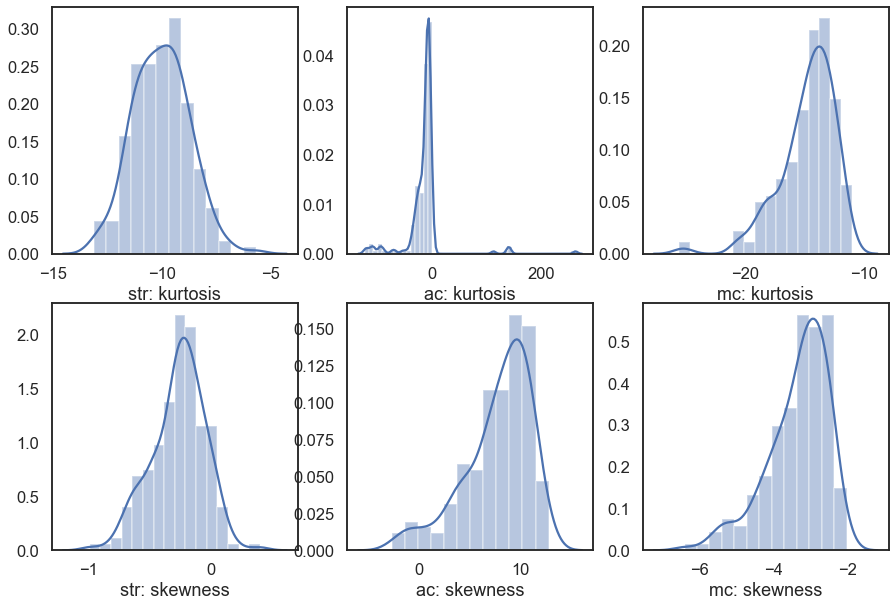

In [26]:
f, axes = plt.subplots(2,len(dwi_metrics))
f.set_figwidth(len(dwi_metrics)*5)
f.set_figheight(10)

for i, metric in enumerate(dwi_metrics):
    kur = np.zeros((df_node.filter(regex = metric).shape[1]))
    skew = np.zeros((df_node.filter(regex = metric).shape[1]))
    for j, node in enumerate(df_node.filter(regex = metric).columns):
        d = sp.stats.zscore(df_node.filter(regex = metric).loc[:,node])
        kur[j] = sp.stats.kurtosistest(d)[0]
        skew[j] = sp.stats.skewtest(d)[0]
    
    sns.distplot(kur, ax = axes[0,i])
    axes[0,i].set_xlabel(metric+': kurtosis')
    sns.distplot(skew, ax = axes[1,i])
    axes[1,i].set_xlabel(metric+': skewness')

In [27]:
my_str = os.environ['MODELDIR'].split('/')[-1]
my_str = my_str.split('_')[-1]
my_str

'streamlineCount'

In [28]:
if my_str == 'nuis-streamline' or my_str == 'nuis-netdens':
    df_node = df_node.filter(regex = 'squeakycleanExclude|str|ac|mc', axis = 1)
elif my_str == 'nuis-str':
    df_str = df_node.filter(regex = 'str', axis = 1).copy()
    df_node = df_node.filter(regex = 'squeakycleanExclude|ac|mc', axis = 1)
else:
    print('skipping...')

skipping...


In [29]:
df_node.shape

(1080, 1001)

## Nuisance regression

In [30]:
df_node_bak = df_node.copy()

In [31]:
# labels of nuisance regressors
nuis = ['averageManualRating']
print(nuis)
df_nuis = df[nuis]
df_nuis = sm.add_constant(df_nuis)

my_str = '|'.join(t1_metrics); print(my_str)
cols = df_node.filter(regex = my_str, axis = 1).columns

mdl = sm.OLS(df_node.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

['averageManualRating']
ct|vol


In [32]:
if my_str == 'nuis-str':
    print('Running strength nuisance regression')
    for col in df_node.filter(regex = 'ac|mc', axis = 1).columns:
        nuis = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
        df_nuis = df[nuis]
        df_nuis = sm.add_constant(df_nuis)

        col_nuis = 'str_' + col.split('_')[1]
        df_nuis.loc[:,'str'] = df_str.loc[:,col_nuis]

        mdl = sm.OLS(df_node.loc[:,col], df_nuis).fit()
        y_pred = mdl.predict(df_nuis)
        df_node.loc[:,col] = df_node.loc[:,col] - y_pred
else:
    if my_str == 'nuis-netdens':
        print('Running network density nuisance regression')
        nuis = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS', 'network_density']
        df_nuis = df[nuis]
    else:
        print('Running standard nuisance regression')
        nuis = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
        df_nuis = df[nuis]
    print(nuis)
    df_nuis = sm.add_constant(df_nuis)

    my_str = '|'.join(dwi_metrics); print(my_str)
    cols = df_node.filter(regex = my_str, axis = 1).columns

    mdl = sm.OLS(df_node.loc[:,cols], df_nuis).fit()
    y_pred = mdl.predict(df_nuis)
    y_pred.columns = cols
    df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

Running standard nuisance regression
['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
str|ac|mc


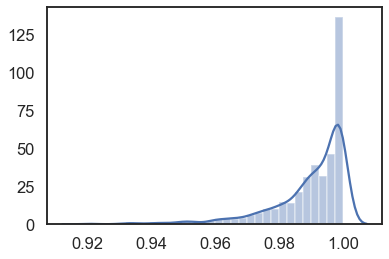

In [33]:
r = np.zeros(df_node.shape[1])
for i, col in enumerate(df_node.columns):
    r[i] = sp.stats.spearmanr(df_node_bak[col],df_node[col])[0]
sns.distplot(r)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


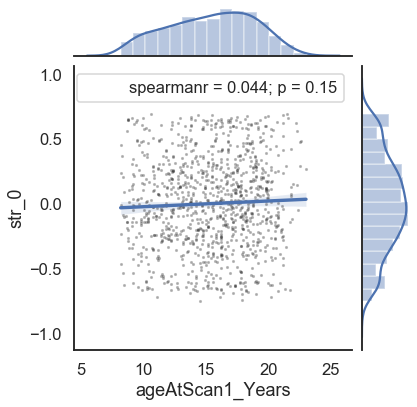

In [34]:
f = sns.jointplot(x = df['ageAtScan1_Years'], y = df_node['str_0'], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


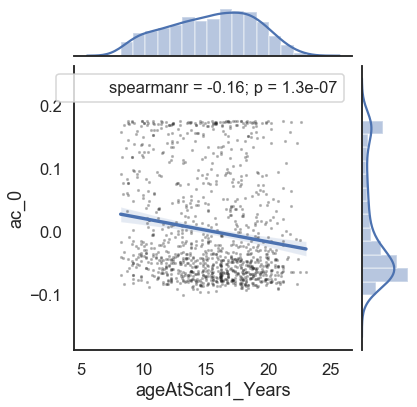

In [35]:
f = sns.jointplot(x = df['ageAtScan1_Years'], y = df_node['ac_0'], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_DWI/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


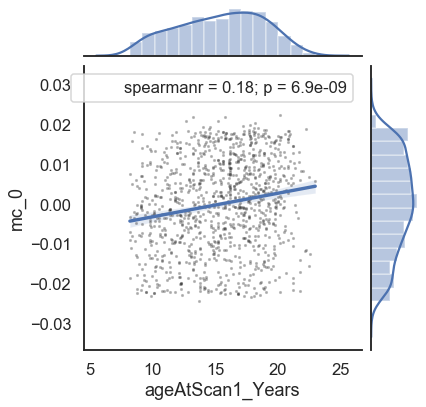

In [36]:
f = sns.jointplot(x = df['ageAtScan1_Years'], y = df_node['mc_0'], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [37]:
df_node.isna().any().any()

False

## Save out

In [38]:
# Save out
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_clean.csv'))
# df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_clean_my_thresh-'+str(my_thresh)+'.csv'))